# 00 Install Dependecies

In [ ]:
!pip install cv2

In [ ]:
!pip install numpy

In [ ]:
!pip install pandas

# 00 Initial Setting

In [1]:
# For image processing
import cv2
import imutils
import numpy as np
import pandas as pd

# For Math
import math
from scipy.stats import norm
from scipy.spatial import cKDTree


# For path
import os
from pathlib import Path

# For displaying
from PIL import Image
from IPython.display import display

# For performance
import time
from multiprocessing import Pool, cpu_count

In [2]:
from util_db import load_db, search_deck, search_digit, search_name
from match_scale import match_scale_mp
from match_card import match_card
from util_trim import trans_raw, trans_dup, trans_group, trans_sort, trans_name, trans_type, trans_paste

In [3]:
cwd = Path.cwd()
dir_main = Path.cwd().parent
n_cpu = cpu_count()

In [4]:
def round_near(x):
    x_f = math.floor(x)
    x_c = math.ceil(x)
    d_f = (x - x_f)
    d_c = (x_c - x)
    x = x_f if d_f < d_c else x_c
    return x

In [5]:
def unique_in_order(lst):
    seen = {}
    result = []
    for item in lst:
        if item not in seen:
            seen[item] = True
            result.append(item)
    return result

In [6]:
df = load_db(True)

In [7]:
db_code = np.asanyarray(df["Code"])
db_digit = np.asarray(df["Digit"])
db_name_ko = np.asarray(df["Name_KO"])
db_type = np.asarray(df['Type'])

In [8]:
ind_hf = df.loc[(df['Staple'] == '범용'), 'Usage'].nlargest(25).index
db_code_freq = db_code[ind_hf]
db_digit_freq = db_digit[ind_hf]
db_name_freq = db_name_ko[ind_hf]

In [9]:
print(db_name_freq)

['증식의 G' '하루 우라라' '하루 우라라' '무한포영' '무덤의 지명자' '원시생명체 니비루' '라이트닝 스톰'
 '졸부와 겸허의 항아리' '길항승부' '드롤 & 로크 버드' '드롤 & 로크 버드' '말살의 지명자' '신의 심판' '해피의 깃털'
 '해피의 깃털' '네가로기어 아제우스' '이펙트 뵐러' '금지된 일적' '삼전의 재' '트윈트위스터' '코즈믹 싸이크론'
 '아티팩트－롱기누스' '스프라이트 엘프' '차원 장벽' '명왕결계파']


In [10]:
# Sample to Test For
card_list_freq = [
    "증식의 G","하루 우라라", "무덤의 지명자", "무한포영",
    "졸부와 겸허의 항아리", "말살의 지명자", "이펙트 뵐러", "삼전의 재",
    "금지된 일적", "어리석은 매장", "테라포밍", "원시생명체 니비루",
    "네가로기어 아제우스", "액세스코드 토커", "소명의 신궁－아폴로우사", "라이트닝 스톰",
    "길항승부", "드롤 & 로크 버드", "해피의 깃털", "신의 심판",
    "트윈트위스터", "코즈믹 싸이크론", "아티팩트－롱기누스", "차원 장벽",
    "레드 리부트", "명왕결계파", "부유벚꽃", "다이너레슬러 판크라톱스",]

In [11]:
dir_card_list_freq = []

for digit in db_digit_freq:
    dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
    dir_card_list_freq.append(dir_card)

img_card_list_freq = []
for dir_card in dir_card_list_freq:
    img_card = cv2.imread(dir_card, 0)
    img_card_list_freq.append(img_card)

In [12]:
db_digit_min = df.loc[df['Usage'] > 0, 'Digit'].tolist()
db_digit_avr = df.loc[df['Possible'], 'Digit'].tolist()
db_digit_max = df.loc[(df['Code'] > 0) & (df['Digit'] > 0), 'Digit'].tolist()

In [13]:
sd_factor = 0.6
db_digit_extra = df.loc[ (df['SD'] > sd_factor) & (df['Type'] == '엑스트라') , 'Digit'].tolist()
db_digit_effect = df.loc[ (df['SD'] > sd_factor) & (df['Typo'] == '효과') , 'Digit'].tolist()
db_digit_magic = df.loc[ (df['SD'] > sd_factor) & (df['Typo'] == '마법') , 'Digit'].tolist()
db_digit_trap = df.loc[ (df['SD'] > sd_factor) & (df['Typo'] == '함정') , 'Digit'].tolist()
db_digit_side_magic = df.loc[ (df['SD'] > sd_factor) & (df['Typo'] == '마법') & (df['U_Side'] > 0), 'Digit'].tolist()
db_digit_side_trap = df.loc[ (df['SD'] > sd_factor) & (df['Typo'] == '함정') & (df['U_Side'] > 0), 'Digit'].tolist()

# 00 Preview Data

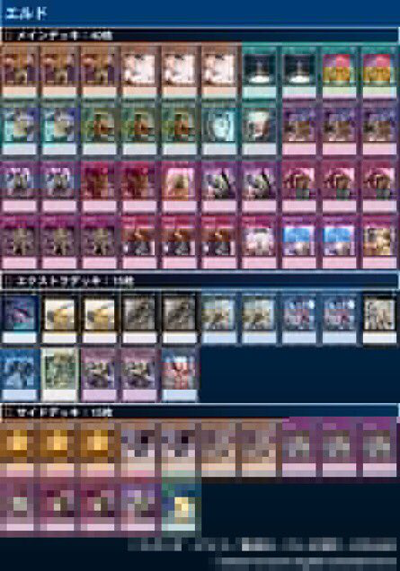

In [14]:
# Find deck path by deck_code
deck_code = '0610-004' 
dir_deck = search_deck(deck_code)
#######################################################
image = Image.open(dir_deck)
o_size = image.size
f = 400
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

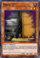

In [15]:
local = 'ko'
card_name = "증식의 G"
digit = search_digit(card_name, local)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
#######################################################
image=Image.open(dir_card)
o_size = image.size
f = 40
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

# 01 Guess Single Card

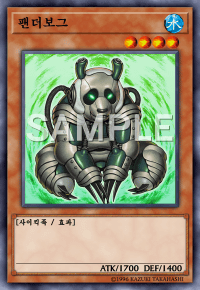

In [16]:
dir_snap_shot = f'{dir_main}/Data/snap_shot.jpg'

image=Image.open(dir_snap_shot)
o_size = image.size
f = 200
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

0610-004 | -Found cache for 038              |
0610-004 | -Loading cache for 038            |
0610-004 | -Loaded cache for 038             | 0.05
____________________________________________________________
팬더보그 | 영혼의 해방 | 파라오의 화신 | 융합체 구제장치
강매 좀비 | 강매 고블린 | 로스트 가디언 | C전장의 지휘관 코로넬
아바키 | 가뭄의 결계상 | 고대 샤크 하이퍼 메가로돈 | 숲의 성수 유니폴리아
가시 벽 | 바늘 맘보 | 스팀 싱크론 | 초노급포탑열차 저거너트 리베
레이더즈 나이트 | 트릭스터 리인카네이션 | 마법 기사 길티어 | 낙천재앙 카르크라그라
나츄르 펌프킨 | 가드 헤지 | 숲의 성수 카르피포니카 | 고블린의 비약
나츄르 스틴크버그 | Kozmo－다크 엘파이버 | 암드 드래곤 썬더 LV5 | 스팀로이드
메테오 레인 | 4515
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
|                        팬더보그                        |


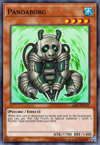

In [17]:
local = 'ko'
snap_shot_width = 40
card_width = math.floor(snap_shot_width * 0.95)
#####################################################################
threshold = 0.5
#####################################################################
dup_tol = math.ceil(card_width/1.95)
sort_round = math.ceil(card_width/1.95)
digit_list = db_digit_max # Specify 
#####################################################################
img_snap = cv2.imread(dir_snap_shot)
img_snap = imutils.resize(img_snap, width = snap_shot_width)
img_snap = cv2.cvtColor(img_snap, cv2.COLOR_BGR2GRAY)
#####################################################################
perf_round = 2
#####################################################################
# Chcek Cache
cache_files = list(dir_main.glob('Output/cache_*.npy'))
cache_names = [Path(file).stem for file in cache_files]
#####################################################################
if f'cache_{card_width:03d}' in cache_names:
    print(f'{deck_code} | -Found cache for {card_width:03d}              |')
else:
    print(f'{deck_code} | -No cache for {card_width:03d}                 |')
    # getting info
    dir_card_list_x = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in db_digit_max]
    # resizing
    tcs = time.perf_counter()
    print(f'{deck_code} | -Saving cache for {card_width:03d}             |')
    load_card_list = [imutils.resize(cv2.imread(dir_card, 0), width=card_width) for dir_card in dir_card_list_x]
    dict_card_list = dict(zip(db_digit_max, load_card_list))
    # saving cache
    dir_cache_card_save = f'{dir_main}/Output/cache_{card_width:03d}.npy'
    np.save(dir_cache_card_save, dict_card_list)
    print(f'{deck_code} | -Saved cache for {card_width:03d}              | { round(time.perf_counter() - tcs , perf_round)}')
#####################################################################
# loading cache
tcl = time.perf_counter()
print(f'{deck_code} | -Loading cache for {card_width:03d}            |')
dir_cache_card_open = f'{dir_main}/Output/cache_{card_width:03d}.npy'
cache_card_list = np.load(dir_cache_card_open, allow_pickle=True)
filter_card_list = [ cache_card_list.item()[digit] for digit in digit_list ]
print(f'{deck_code} | -Loaded cache for {card_width:03d}             | { round(time.perf_counter() - tcl , perf_round)}')
#####################################################################
card_loc = []
card_pos = []
for img_card in filter_card_list:
    res = cv2.matchTemplate(img_snap, img_card, cv2.TM_CCOEFF_NORMED)
    loc=np.where(res >= threshold)
    num_loc = tuple(zip(*loc[::-1]))
    num_pos = res[loc]
    card_loc.append(num_loc)
    card_pos.append(num_pos)
#####################################################################
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
#######################################################
zip_list = list(zip(zip_digit, zip_pos))
sorted_zip_list = sorted(zip_list, key=lambda x: x[1], reverse=True)
sorted_digit = [zip[0] for zip in sorted_zip_list]
set_digit = unique_in_order(sorted_digit)
#######################################################
names = trans_name(set_digit, local)
names = names[:30]
#######################################################
items_per_line = 4
separator = ' | '
print('_'*60)
# Iterate over the items and print them in groups
for i in range(0, len(names), items_per_line):
    print(separator.join(  names[i:i+items_per_line]  ))
print('‾'*60)
print(f'| {names[0]:^50} |')
#######################################################
card_name = names[0]
digit = search_digit(card_name, local)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
#######################################################
image=Image.open(dir_card)
o_size = image.size
f = 100
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)
#######################################################

## 01 Guessing Blured Card

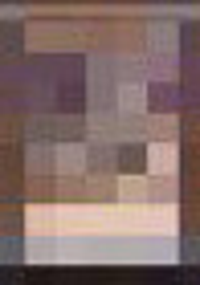

In [18]:
dir_snap_shot = f'{dir_main}/Data/snap_05.jpg'

image=Image.open(dir_snap_shot)
o_size = image.size
f = 200
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

0610-004 | -Found cache for 038              |
0610-004 | -Loading cache for 038            |
0610-004 | -Loaded cache for 038             | 0.06
____________________________________________________________
인스펙트 보더 | No－P.U.N.K. 오우거 넘버 | 데스피아의 아드리비툼 | 자독의 마술사
세리온즈 "킹" 레귤러스 | 미계역의 빅풋 | 파괴검－드래곤버스터블레이드 | 재빠른 비버
티아라멘츠 셰이렌 | 팬텀 나이츠 티어스케일 | 비스테드 마그나무트 | 플래닛 패스파인더
비스테드 살로니르 | 후완다리즈×로비나 | 크샤트리라 라이즈하트 | 비스테드 발드레이크
데스티니 히어로 디아볼릭 가이 | 흑아의 마술사 | 열풍의 결계상 | 드라이트론－엘γ
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
|                      인스펙트 보더                       |


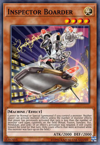

In [19]:
local = 'ko'
snap_shot_width = 40
card_width = math.floor(snap_shot_width * 0.95)
#####################################################################
threshold = 0.5
#####################################################################
dup_tol = math.ceil(card_width/1.95)
sort_round = math.ceil(card_width/1.95)
digit_list = db_digit_effect # Specify 
#####################################################################
img_snap = cv2.imread(dir_snap_shot)
img_snap = imutils.resize(img_snap, width = snap_shot_width)
img_snap = cv2.cvtColor(img_snap, cv2.COLOR_BGR2GRAY)
#####################################################################
perf_round = 2
#####################################################################
# Chcek Cache
cache_files = list(dir_main.glob('Output/cache_*.npy'))
cache_names = [Path(file).stem for file in cache_files]
#####################################################################
if f'cache_{card_width:03d}' in cache_names:
    print(f'{deck_code} | -Found cache for {card_width:03d}              |')
else:
    print(f'{deck_code} | -No cache for {card_width:03d}                 |')
    # getting info
    dir_card_list_x = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in db_digit_max]
    # resizing
    tcs = time.perf_counter()
    print(f'{deck_code} | -Saving cache for {card_width:03d}             |')
    load_card_list = [imutils.resize(cv2.imread(dir_card, 0), width=card_width) for dir_card in dir_card_list_x]
    dict_card_list = dict(zip(db_digit_max, load_card_list))
    # saving cache
    dir_cache_card_save = f'{dir_main}/Output/cache_{card_width:03d}.npy'
    np.save(dir_cache_card_save, dict_card_list)
    print(f'{deck_code} | -Saved cache for {card_width:03d}              | { round(time.perf_counter() - tcs , perf_round)}')
#####################################################################
# loading cache
tcl = time.perf_counter()
print(f'{deck_code} | -Loading cache for {card_width:03d}            |')
dir_cache_card_open = f'{dir_main}/Output/cache_{card_width:03d}.npy'
cache_card_list = np.load(dir_cache_card_open, allow_pickle=True)
filter_card_list = [ cache_card_list.item()[digit] for digit in digit_list ]
print(f'{deck_code} | -Loaded cache for {card_width:03d}             | { round(time.perf_counter() - tcl , perf_round)}')
#####################################################################
card_loc = []
card_pos = []
for img_card in filter_card_list:
    res = cv2.matchTemplate(img_snap, img_card, cv2.TM_CCOEFF_NORMED)
    loc=np.where(res >= threshold)
    num_loc = tuple(zip(*loc[::-1]))
    num_pos = res[loc]
    card_loc.append(num_loc)
    card_pos.append(num_pos)
#####################################################################
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
#######################################################
zip_list = list(zip(zip_digit, zip_pos))
sorted_zip_list = sorted(zip_list, key=lambda x: x[1], reverse=True)
sorted_digit = [zip[0] for zip in sorted_zip_list]
set_digit = unique_in_order(sorted_digit)
#######################################################
names = trans_name(set_digit, local)
names = names[:20]
#######################################################
items_per_line = 4
separator = ' | '
print('_'*60)
# Iterate over the items and print them in groups
for i in range(0, len(names), items_per_line):
    print(separator.join(  names[i:i+items_per_line]  ))
print('‾'*60)
print(f'| {names[0]:^50} |')
#######################################################
card_name = names[0]
digit = search_digit(card_name, local)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
#######################################################
image=Image.open(dir_card)
o_size = image.size
f = 100
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)
#######################################################

# 2 Using Simple Card Pool

### 2-1 Parameters

In [20]:
# Parameters
local = 'ko'
#######################################################
# Find deck path by deck_code
deck_code = '1354-003' # check for image named deck_code under Deck folder
dir_deck = search_deck(deck_code)
#######################################################
deck_width = 400
print(f'{deck_code} | Width of Deck         | {deck_width}')
#######################################################
img_deck = cv2.imread(dir_deck)
img_deck = imutils.resize(img_deck, width = deck_width)
img_deck = cv2.cvtColor(img_deck, cv2.COLOR_BGR2GRAY)
#######################################################
exp_card_width = deck_width/10
card_min = int(exp_card_width *0.8) 
card_max = int(exp_card_width *1.1)
step = card_max-card_min+1
#######################################################
threshold = 0.9
card_width_list = []
for img_card in img_card_list_freq:
    card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
    if card_width != None:
        card_width_list.append(card_width)
#######################################################
try:
    card_width = round_near(sum(card_width_list) / len(card_width_list))
    print(f'{deck_code} | Width of Card         | {card_width}')
except ZeroDivisionError:
    card_width = round_near(exp_card_width)
    print(f"{deck_code} | Width of Card; Zero Div Error | {card_width}")
print(f'-- {card_width_list} --' )
#######################################################
dup_tol = math.ceil(card_width/1.95)
sort_round = math.ceil(card_width/1.95)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
digit_list = db_digit_freq
dir_card_list = dir_card_list_freq
print(f'{deck_code} | Cards to match        | {len(dir_card_list)}')
#######################################################

1354-003 | Width of Deck         | 400
1354-003 | Width of Card         | 39
-- [39, 39, 39, 39, 39] --
1354-003 | Matchng Threshold     | 0.9
1354-003 | Duplicate Tolearance  | 20
1354-003 | Sorting Round         | 20
1354-003 | Cards to match        | 25


In [21]:
# Load images and resize for card_width 
img_card_list = []
for dir_card in dir_card_list:
    img_card = cv2.imread(dir_card, 0)
    img_card = imutils.resize(img_card, width = card_width)
    img_card_list.append(img_card)

In [22]:
# def load_and_resize_image(dir_card, card_width):
#     img_card = Image.open(dir_card).convert('L')
#     img_card = np.array(img_card)
#     img_card = np.resize(img_card, (int(img_card.shape[0] * card_width / img_card.shape[1]), card_width))
#     return img_card

# # Load and resize all images using the function
# img_card_list = [load_and_resize_image(dir_card, card_width) for dir_card in dir_card_list]

### 2-2 Solver 

In [23]:
args = [
    [img_card, img_deck, threshold]
    for img_card in img_card_list
]
#####################################################################
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card, args)
pool.close()
#####################################################################
card_loc = [item[0] for item in result]
card_pos = [item[1] for item in result]
#####################################################################
# Translator
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
dup_pt, dup_ind = trans_dup (zip_pt, dup_tol)
group_pt, group_pos, group_digit = trans_group (dup_ind, zip_pt, zip_pos, zip_digit)
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
sort_name = trans_name(sort_digit, local)
sort_type = trans_type(sort_digit)
deck_list = trans_paste(sort_name, sort_type, deck_code)
print(sort_name)
#####################################################################
master_db = ["\t".join(str(x) for x in deck_list)]
dir_write = f'{dir_main}/Output/single_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)

['증식의 G', '증식의 G', '증식의 G', '삼전의 재', '코즈믹 싸이크론', '코즈믹 싸이크론', '해피의 깃털', '라이트닝 스톰']


# 3 Using Compact DB

### 3-1 Parameters

1354-003 | Width of Deck         | 400
1354-003 | Width of Card         | 39
-- [39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 38, 39] --
1354-003 | Matchng Threshold     | 0.75
1354-003 | Duplicate Tolearance  | 19
1354-003 | Sorting Round         | 19
1354-003 | Cards to match        | 2753


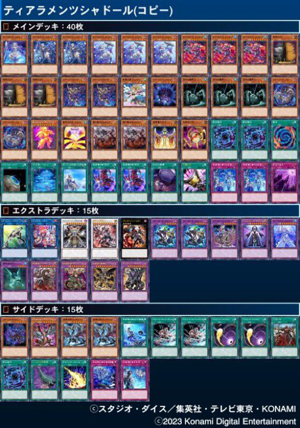

In [29]:
# Parameters
local = 'ko'
#######################################################
# Find deck path by deck_code
deck_code = '1354-003'
dir_deck = search_deck(deck_code)
#######################################################
deck_width = 400
print(f'{deck_code} | Width of Deck         | {deck_width}')
#######################################################
img_deck = cv2.imread(dir_deck)
img_deck = imutils.resize(img_deck, width = deck_width)
img_deck = cv2.cvtColor(img_deck, cv2.COLOR_BGR2GRAY)
#######################################################
exp_card_width = deck_width/10
card_min = int(exp_card_width *0.8) 
card_max = int(exp_card_width *1.1)
step = card_max-card_min+1
#######################################################
threshold = 0.75
card_width_list = []
for img_card in img_card_list_freq:
    card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
    if card_width != None:
        card_width_list.append(card_width)
#######################################################
try:
    card_width = round_near(sum(card_width_list) / len(card_width_list))
    print(f'{deck_code} | Width of Card         | {card_width}')
except ZeroDivisionError:
    card_width = round_near(exp_card_width)
    print(f"{deck_code} | Width of Card; Zero Div Error | {card_width}")
print(f'-- {card_width_list} --' )
#######################################################
dup_tol = math.floor(card_width / 2)
sort_round = math.floor(card_width / 2)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
digit_list = db_digit_min
dir_card_list = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in digit_list]
print(f'{deck_code} | Cards to match        | {len(dir_card_list)}')
#######################################################
image = Image.open(dir_deck)
o_size = image.size
f = 300
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

### 3-2 Solver

In [34]:
print(f'{deck_code} | Started Process                   | Run')
print(f'{deck_code} | -Converting Image for {card_width:03d}         | { round(time.perf_counter() - t1 , perf_round)}')
print(f'{deck_code} | -Converted Image for {card_width:03d}          | { round(time.perf_counter() - t1 , perf_round)}')


1357-003 | Started Process                   | Run
1357-003 | -Converting Image for 039         | 149.55
1357-003 | -Converted Image for 039          | 149.55


In [35]:
# Solver
perf_round = 2
print(f'{deck_code} | Started Process                   | Run')
t1 = time.perf_counter()
#####################################################################
# Load images and resize for card_width 
print(f'{deck_code} | -Converting Image for {card_width:03d}         |')
img_card_list = []
for dir_card in dir_card_list:
    img_card = cv2.imread(dir_card, 0)
    img_card = imutils.resize(img_card, width = card_width)
    img_card_list.append(img_card)
print(f'{deck_code} | -Converted Image for {card_width:03d}          | { round(time.perf_counter() - t1 , perf_round)}')
#####################################################################
args = [
    [img_card, img_deck, threshold]
    for img_card in img_card_list
]
#####################################################################
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card, args)
pool.close()
print(f"{deck_code} | -Finished Template Matching in    | { round(time.perf_counter() - t1 , perf_round)}")
#####################################################################
t2 = time.perf_counter()
card_loc = [item[0] for item in result]
card_pos = [item[1] for item in result]
#####################################################################
# Translator
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
dup_pt, dup_ind = trans_dup (zip_pt, dup_tol)
group_pt, group_pos, group_digit = trans_group (dup_ind, zip_pt, zip_pos, zip_digit)
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
sort_name = trans_name(sort_digit, local)
sort_type = trans_type(sort_digit)
deck_list = trans_paste(sort_name, sort_type, deck_code)
print(f"{deck_code} | -Finished Translating in          | { round(time.perf_counter() - t2 , perf_round)}")
#####################################################################
master_db = ["\t".join(str(x) for x in deck_list)]
dir_write = f'{dir_main}/Output/single_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)
print(f"{deck_code} | Finished Process in               | = { round(time.perf_counter() - t1 , perf_round)}")

1357-003 | Started Process                   | Run
1357-003 | -Converting Image for 039         |
1357-003 | -Converted Image for 039          | 6.87
1357-003 | -Finished Template Matching in    | 10.53
1357-003 | -Finished Translating in          | 0.19
1357-003 | Finished Process in               | = 10.86


### Exporter

In [14]:
# Export Data
package = []
for i in range(len(digit_list)):
    digit = digit_list[i]
    for j in range(len(card_loc[i])):
        coord = card_loc[i][j]
        coX = coord[0]
        coY = coord[1]
        pos = card_pos[i][j]
        ind = np.where(db_digit == int(digit))[0][0]
        name = np.asarray(df[f"Name_{local.upper()}"])[ind]
        package.append(f'{coX}, {coY}, {digit}, {pos}, {name}')

dir_write = f'{dir_main}\Output\package.txt'
with open(dir_write, 'w', encoding="utf-8") as fp:
    for item in package:
        fp.write("%s\n" % item)

# 4 Using Cache

### 4-1 Parameters

1354-003 | Width of Deck         | 400
1354-003 | Width of Card         | 39
-- [39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 38, 39] --
1354-003 | Matchng Threshold     | 0.75
1354-003 | Duplicate Tolearance  | 19
1354-003 | Sorting Round         | 19
1354-003 | Cards to match        | 7436
1354-003 | Decks to match        | 11


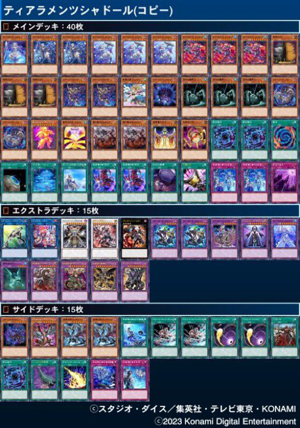

In [37]:
# Parameters
local = 'ko'
#######################################################
# Find deck path by deck_code
deck_code = '1354-003'
dir_deck = search_deck(deck_code)
#######################################################
deck_width = 400
print(f'{deck_code} | Width of Deck         | {deck_width}')
img_deck = cv2.cvtColor(imutils.resize(cv2.imread(dir_deck), width=deck_width), cv2.COLOR_BGR2GRAY)
#######################################################
exp_card_width = deck_width/10
card_min = int(exp_card_width *0.8) 
card_max = int(exp_card_width *1.1)
step = card_max-card_min+1
#######################################################
threshold = 0.75
card_width_list = []
for img_card in img_card_list_freq:
    card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
    if card_width != None:
        card_width_list.append(card_width)
#######################################################
try:
    card_width = round_near(sum(card_width_list) / len(card_width_list))
    print(f'{deck_code} | Width of Card         | {card_width}')
except ZeroDivisionError:
    card_width = round_near(exp_card_width)
    print(f"{deck_code} | Width of Card; Zero Div Error | {card_width}")
print(f'-- {card_width_list} --' )
#######################################################
dup_tol = math.floor(card_width / 2)
sort_round = math.floor(card_width / 2)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
digit_list = db_digit_avr
dir_card_list = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in digit_list]
print(f'{deck_code} | Cards to match        | {len(dir_card_list)}')
#######################################################
dir_deck_db = f'{dir_main}/Data/deck_db.txt'
deck_code_list = np.loadtxt(dir_deck_db, dtype='str')
dir_deck_list = [
    f"{dir_main}/Deck/{deck_code}.jpg" for deck_code in deck_code_list
]
print(f'{deck_code} | Decks to match        | {len(dir_deck_list)}')
#######################################################
image = Image.open(dir_deck)
o_size = image.size
f = 300
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

### 4-2 Test Card Widths for list of decks

In [36]:
average_list = []
for dir_deck in dir_deck_list[:10]:
    deck_code = Path(dir_deck).stem
    card_width_list = []
    for img_card in img_card_list_freq:
        card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
        if card_width != None:
            card_width_list.append(card_width)
    try:
        average = round_near(sum(card_width_list) / len(card_width_list))
        average_list.append(average)
        print(f'{deck_code} | average card width is : {average}')
    except ZeroDivisionError:
        print(f'{deck_code} | Zero Division Error')

list_average = round_near(sum(average_list) / len(average_list))
print(f'-- average card width overall {list_average} --')

1355-001 | average card width is : 39
1355-002 | average card width is : 39
1355-003 | average card width is : 39
1355-004 | average card width is : 39
1356-001 | average card width is : 39
1356-002 | average card width is : 39
1356-003 | average card width is : 39
1357-001 | average card width is : 39
1357-002 | average card width is : 39
1357-003 | average card width is : 39
-- average card width overall 39 --


### 4-3 Single Instance

In [31]:
## Solution
print(f'{deck_code} | Started Process                   | Run')
perf_round = 2
t1 = time.perf_counter()
#####################################################################
# Chcek Cache
cache_files = list(dir_main.glob('Output/cache_*.npy'))
cache_names = [Path(file).stem for file in cache_files]
#####################################################################
if f'cache_{card_width:03d}' in cache_names:
    print(f'{deck_code} | -Found cache for {card_width:03d}              |')
else:
    print(f'{deck_code} | -No cache for {card_width:03d}                 |')
    # getting info
    dir_card_list_x = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in db_digit_max]
    # resizing
    tcs = time.perf_counter()
    print(f'{deck_code} | -Saving cache for {card_width:03d}             |')
    load_card_list = [imutils.resize(cv2.imread(dir_card, 0), width=card_width) for dir_card in dir_card_list_x]
    dict_card_list = dict(zip(db_digit_max, load_card_list))
    # saving cache
    dir_cache_card_save = f'{dir_main}/Output/cache_{card_width:03d}.npy'
    np.save(dir_cache_card_save, dict_card_list)
    print(f'{deck_code} | -Saved cache for {card_width:03d}              | { round(time.perf_counter() - tcs , perf_round)}')
#####################################################################
# loading cache
tcl = time.perf_counter()
print(f'{deck_code} | -Loading cache for {card_width:03d}            |')
dir_cache_card_open = f'{dir_main}/Output/cache_{card_width:03d}.npy'
cache_card_list = np.load(dir_cache_card_open, allow_pickle=True)
filter_card_list = [ cache_card_list.item()[digit] for digit in digit_list ]
print(f'{deck_code} | -Loaded cache for {card_width:03d}             | { round(time.perf_counter() - tcl , perf_round)}')
#####################################################################
# Variables
tm = time.perf_counter()
args = [[img_card, img_deck, threshold] for img_card in filter_card_list]
#####################################################################
# Solver
print(f'{deck_code} | -Starting Templating Matching     | { round(time.perf_counter() - tm , perf_round)}')
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card, args)
pool.close()
#####################################################################
print(f"{deck_code} | -Finished Template Matching in    | { round(time.perf_counter() - tm , perf_round)}")
t2 = time.perf_counter()
#####################################################################
card_loc = [item[0] for item in result]
card_pos = [item[1] for item in result]
#####################################################################
# Translator
tt = time.perf_counter()
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
print(f"{deck_code} |     Converting 1 : Raw            | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
dup_pt, dup_ind = trans_dup (zip_pt, dup_tol)
print(f"{deck_code} |     Converting 2 : Dup            | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
group_pt, group_pos, group_digit = trans_group (dup_ind, zip_pt, zip_pos, zip_digit)
print(f"{deck_code} |     Converting 3 : Group          | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
print(f"{deck_code} |     Converting 4 : Sort           | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
sort_name = trans_name(sort_digit, local)
print(f"{deck_code} |     Converting 5 : Name           | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
sort_type = trans_type(sort_digit)
print(f"{deck_code} |     Converting 6 : Type           | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
deck_list = trans_paste(sort_name, sort_type, deck_code)
print(f"{deck_code} |     Converting 7 : Paste          | { round(time.perf_counter() - tt , perf_round)}")
#####################################################################
master_db = ["\t".join(str(x) for x in deck_list)]
#####################################################################
print(f"{deck_code} | -Finished Translating in          | { round(time.perf_counter() - t2 , perf_round)}")
print(f"{deck_code} | Finished Process in               | = { round(time.perf_counter() - t1 , perf_round)}")
#####################################################################
dir_write = f'{dir_main}\Output\single_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)

1357-003 | Started Process                   | Run
1357-003 | -Found cache for 039              |
1357-003 | -Loading cache for 039            |
1357-003 | -Loaded cache for 039             | 0.06
1357-003 | -Starting Templating Matching     | 0.0
1357-003 | -Finished Template Matching in    | 3.74
1357-003 |     Converting 1 : Raw            | 0.01
1357-003 |     Converting 2 : Dup            | 0.18
1357-003 |     Converting 3 : Group          | 0.0
1357-003 |     Converting 4 : Sort           | 0.01
1357-003 |     Converting 5 : Name           | 0.0
1357-003 |     Converting 6 : Type           | 0.0
1357-003 |     Converting 7 : Paste          | 0.0
1357-003 | -Finished Translating in          | 0.2
1357-003 | Finished Process in               | = 3.99


### 4-3-1 Exporter

In [19]:
# Export Data
package = []
for i in range(len(digit_list)):
    digit = digit_list[i]
    for j in range(len(card_loc[i])):
        coord = card_loc[i][j]
        coX = coord[0]
        coY = coord[1]
        pos = card_pos[i][j]
        ind = np.where(db_digit == int(digit))[0][0]
        name = np.asarray(df[f"Name_{local.upper()}"])[ind]
        package.append(f'{coX}, {coY}, {digit}, {pos}, {name}')
package.append(deck_code)
dir_write = f'{dir_main}\Output\package.txt'
with open(dir_write, 'w', encoding="utf-8") as fp:
    for item in package:
        fp.write("%s\n" % item)

### 4-4 Multiple Instance

In [39]:
perf_round = 2
t0 = time.perf_counter()
it_a, it_b = 0, 11
initial_width = None
master_db = []
for i in range(it_a,it_b):
    #####################################################################
    deck_code = deck_code_list[i]
    dir_deck = dir_deck_list[i]
    #####################################################################
    print('======================================================')
    print(f'{deck_code} | Started Process                   | Run {i}/{it_b}')
    t1 = time.perf_counter()
    #####################################################################
    img_deck = cv2.cvtColor(imutils.resize(cv2.imread(dir_deck), width=deck_width), cv2.COLOR_BGR2GRAY)
    card_width_list = []
    for img_card in img_card_list_freq:
        card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
        if card_width != None:
            card_width_list.append(card_width)
    #######################################################
    print(f'{deck_code} | -Width of Deck                    | {deck_width}')
    try:
        card_width = round_near(sum(card_width_list) / len(card_width_list))
        pass_token = True
        print(f'{deck_code} | -Width of Card                    | {card_width}')
    except ZeroDivisionError:
        card_width = round_near(exp_card_width)
        pass_token = False
        print(f"{deck_code} | -Width of Card; Zero Div Error    | {card_width}")
    #######################################################
    dup_tol = math.floor(card_width / 2)
    sort_round = math.floor(card_width / 2)
    #####################################################################
    cache_files = list(dir_main.glob('Output/cache_*.npy'))
    cache_names = [Path(file).stem for file in cache_files]
    #####################################################################
    # checking cache
    if f'cache_{card_width:03d}' in cache_names:
        print(f'{deck_code} | -Found cache for {card_width:03d}              |')
    else:
        print(f'{deck_code} | -No cache for {card_width:03d}                 |')
        # getting info
        dir_card_list_x = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in db_digit_max]
        #####################################################################
        tcs = time.perf_counter()
        print(f'{deck_code} | -Saving cache for {card_width:03d}             |')
        #####################################################################
        # resizing
        load_card_list = [imutils.resize(cv2.imread(dir_card, 0), width=card_width) for dir_card in dir_card_list_x]
        dict_card_list = dict(zip(db_digit_max , load_card_list))
        # saving cache
        dir_cache_card_save = f'{dir_main}/Output/cache_{card_width:03d}.npy'
        np.save(dir_cache_card_save, dict_card_list)
        print(f'{deck_code} | -Saved cache for {card_width:03d}              | { round(time.perf_counter() - tcs , perf_round)}')
    #####################################################################
    # loading cache
    tcl = time.perf_counter()
    print(f'{deck_code} | -Loading cache for {card_width:03d}            |')
    if initial_width and initial_width == card_width:
        filter_card_list = filter_card_list
        print(f'{"Use Privious Cache":^50}')
    else:
        dir_cache_card_open = f'{dir_main}/Output/cache_{card_width:03d}.npy'
        cache_card_list = np.load(dir_cache_card_open, allow_pickle=True)
        filter_card_list = [ cache_card_list.item()[digit] for digit in digit_list ]
    initial_width = card_width
    print(f'{deck_code} | -Loaded cache for {card_width:03d}             | { round(time.perf_counter() - tcl , perf_round)}')
    #####################################################################
    # Variables
    tm = time.perf_counter()
    args = [[img_card, img_deck, threshold] for img_card in filter_card_list]
    #####################################################################
    # Solver
    print(f'{deck_code} | -Starting Templating Matching     | { round(time.perf_counter() - tm , perf_round)}')
    if pass_token:
        with Pool(n_cpu-1) as pool:
            result = pool.starmap(match_card, args)
        pool.close()
    else:
        print(f'{"Pass Template Matching":^50}')
    #####################################################################
    print(f"{deck_code} | -Finished Template Matching in    | { round(time.perf_counter() - tm , perf_round)}")
    t2 = time.perf_counter()
    #####################################################################
    if pass_token:
        card_loc = [item[0] for item in result]
        card_pos = [item[1] for item in result]
    #####################################################################
    # Translator
    if pass_token:
        tt = time.perf_counter()
        zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
        print(f"{deck_code} |     Converting 1 : Raw            | { round(time.perf_counter() - tt , perf_round)}")

        tt = time.perf_counter()
        dup_pt, dup_ind = trans_dup (zip_pt, dup_tol)
        print(f"{deck_code} |     Converting 2 : Dup            | { round(time.perf_counter() - tt , perf_round)}")

        tt = time.perf_counter()
        group_pt, group_pos, group_digit = trans_group (dup_ind, zip_pt, zip_pos, zip_digit)
        print(f"{deck_code} |     Converting 3 : Group          | { round(time.perf_counter() - tt , perf_round)}")

        tt = time.perf_counter()
        sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
        print(f"{deck_code} |     Converting 4 : Sort           | { round(time.perf_counter() - tt , perf_round)}")

        tt = time.perf_counter()
        sort_name = trans_name(sort_digit, local)
        print(f"{deck_code} |     Converting 5 : Name           | { round(time.perf_counter() - tt , perf_round)}")

        tt = time.perf_counter()
        sort_type = trans_type(sort_digit)
        print(f"{deck_code} |     Converting 6 : Type           | { round(time.perf_counter() - tt , perf_round)}")
        
        tt = time.perf_counter()
        deck_list = trans_paste(sort_name, sort_type, deck_code)
        print(f"{deck_code} |     Converting 7 : Paste          | { round(time.perf_counter() - tt , perf_round)}")
    else: # If no card with is found
        deck_list = [deck_code, 'Error, No Card Found']
    #####################################################################
    master_db.append("\t".join(str(x) for x in deck_list))
    #####################################################################
    print(f"{deck_code} | -Finished Translating in          | { round(time.perf_counter() - t2 , perf_round)}")
    print(f"{deck_code} | Finished Process in               | = { round(time.perf_counter() - t1 , perf_round)}")
    #####################################################################
dir_write = f'{dir_main}\Output\mp_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)
print(f'         | Gross Computation                 | = { round(time.perf_counter() - t0 , perf_round)}')

1355-001 | Started Process                   | Run 0/11
1355-001 | -Width of Deck                    | 400
1355-001 | -Width of Card                    | 39
1355-001 | -Found cache for 039              |
1355-001 | -Loading cache for 039            |
1355-001 | -Loaded cache for 039             | 0.05
1355-001 | -Starting Templating Matching     | 0.01
1355-001 | -Finished Template Matching in    | 8.48
1355-001 |     Converting 1 : Raw            | 0.01
1355-001 |     Converting 2 : Dup            | 0.35
1355-001 |     Converting 3 : Group          | 0.01
1355-001 |     Converting 4 : Sort           | 0.03
1355-001 |     Converting 5 : Name           | 0.0
1355-001 |     Converting 6 : Type           | 0.0
1355-001 |     Converting 7 : Paste          | 0.0
1355-001 | -Finished Translating in          | 0.41
1355-001 | Finished Process in               | = 9.97
1355-002 | Started Process                   | Run 1/11
1355-002 | -Width of Deck                    | 400
1355-002 | -Width o